# Importing Libraries

In [48]:
import os
import sys
import random
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label


import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout , Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

In [28]:
img_height = 128
img_width = 128
img_chnl = 3

train_path = "./Classifier/U_NET/train/"
test_path = "./Classifier/U_NET/validation/"

warnings.filterwarnings("ignore", category = UserWarning, module = "skimage")
np.random.seed(42)

In [29]:
train_ids = next(os.walk(train_path))[1]
test_ids = next(os.walk(test_path))[1]

# Creating image mask of dimension 128x128

In [30]:
print("Getting and resizeing traing images...")

X_train = np.zeros((len(train_ids),img_height, img_width,img_chnl),dtype = np.uint8)
y_train = np.zeros((len(train_ids),img_height, img_width, 1), dtype = np.bool)

## sys.stout prints info that can be cleared unlike print
## using tqdm allows us to create progress bar

sys.stdout.flush()
for n , id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
    
    path = train_path + id_
    img = imread(path +"/images/" + id_ +".png")[:,:,:img_chnl]
    img = resize(img,(img_height, img_width), mode = "constant", preserve_range = True)
    X_train[n] = img
    mask = np.zeros((img_height, img_width,1),dtype = np.bool)
    
    #now we take all mask associated with that images and combine them into one single mask
    for mask_file in next(os.walk(path + "/masks/"))[2]:
        mask_ = imread(path + "/masks/"+ mask_file)
        mask_ = np.expand_dims(resize(mask_,(img_height, img_width), mode = "constant",
                                      preserve_range = True),axis = -1)
        mask = np.maximum(mask, mask_)
        
    y_train[n] = mask
    
#Get and resize test images
X_test = np.zeros((len(test_ids),img_height, img_width, img_chnl), dtype = np.uint8)
sizes_test = []
print("Getting and reizeing test image")

sys.stdout.flush()

#resize the test imges
for n, id_ in tqdm(enumerate(test_ids), total = len(test_ids)):
    path = test_path + id_
    img = imread(path +"/images/"+ id_ +".png")[:,:,:img_chnl]
    sizes_test.append([img.shape[0],img.shape[1]])
    img = resize(img,(img_height, img_width), mode = "constant", preserve_range = True)
    X_test[n] = img
    

print("Done")

Getting and resizeing traing images...


100%|█████████████████████████████████████████| 670/670 [09:02<00:00,  1.24it/s]

Getting and reizeing test image



100%|███████████████████████████████████████████| 65/65 [00:03<00:00, 18.08it/s]

Done


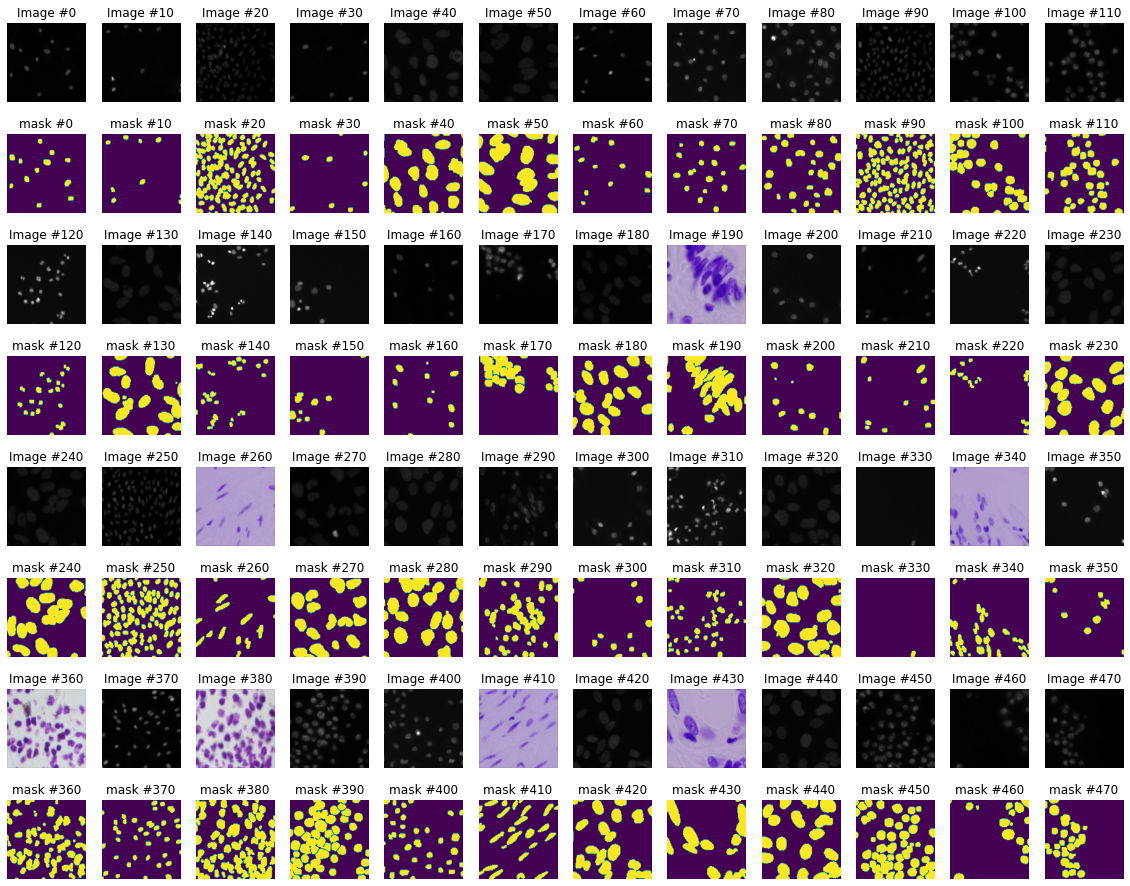

In [38]:
#illustrateges the train images and mask

plt.figure(figsize = (20,16))

x, y = 12, 4

for i in range(y):
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i *120 + j*10
        plt.imshow(X_train[pos])
        plt.title("Image #{}".format(pos))
        plt.axis("off")
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        
        #displaying the associated mask that just generated above the image
        plt.imshow(np.squeeze(y_train[pos]))
        plt.title("mask #{}".format(pos))
        plt.axis("off")
        
        
plt.show()

# Intersection over union metric

In [35]:
def iou_metric(y_true, y_pred):
    prec = []
    
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.iou_metric(y_true, y_pred_, 2,y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identify(score)
        prec.append(score)
    
    return K.mean(K.stack(prec), axis = 0)

In [36]:
# Alternative Iou function

def coef_iou(y_true, y_pred, smooth = 1):
    
    intersection = K.sum(K.abs(y_true*y_pred),axis = 1 )
    union = K.sum((y_true, -1)+ K.sum(y_pred, -1)- intersection)
    
    return(intersection+smooth)/ (union+smooth)

def iou_coef_loss(y_true, y_pred):
    return -coef_iou(y_true, y_pred)

In [79]:
# Another IOU metric function

def iou_met(y_true_in, y_pred_in, print_table = False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_obj = len(np.unique(labels))
    pred_obj = len(np.unique(y_pred))
    
    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins = (true_obj, pred_obj))[0]
    
    #compute_areas
    area_true = np.histogram(labels, bins = true_obj)[0]
    area_pred = np.histogram(y_pred, bins = pred_obj)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)
    
    union = area_true + area_pred - intersection
    
    #Exclude background from analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9
    
    
    iou = intersection/ union
    
    
    def precision_at(threshold,iou):
        matches = iou > threshold
        true_positive = np.sum(matches, axis = 1) == 1
        false_positive = np.sum(matches, axis = 0) == 0
        false_negative = np.sum(matches, axis = 1) == 0
        tp,fp,fn = np.sum(true_positive), np.sum(false_positive), np.sum(false_negative)
        
        return tp, fp, fn
    
    #loop over iou threshold
    prec = []
    
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
        
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp+fp+fn) > 0:
            p = tp/(tp+fp+fn)
            
        else:
            p = 0
            
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t,tp, fp, fn, p))
            
        prec.append(p)
        
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
        
    return np.mean(prec)

def iou_met_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_met(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    
    return np.array(np.mean(metric), dtype = np.float32)

def my_iou_met(label,pred):
    metric_value = tf.py_function(iou_met_batch, [label,pred], tf.float32)
    return metric_value

# Building U-NET

In [80]:
#make our layer variables so that we can concatenate or stack
#this is required so that we can rebuild our u-net model

inputs = Input((img_height, img_width, img_chnl))
s = Lambda(lambda x: x/255)(inputs)

c1 = Conv2D(16,(3,3),activation = "elu", kernel_initializer = "he_normal", padding = "same")(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16,(3,3),activation = "elu", kernel_initializer = "he_normal", padding = "same")(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(32,(3,3),activation = "elu", kernel_initializer = "he_normal", padding = "same")(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32,(3,3),activation = "elu", kernel_initializer = "he_normal", padding = "same")(c2)
p2 = MaxPooling2D((2,2))(c2)


c3 = Conv2D(64,(3,3),activation = "elu", kernel_initializer = "he_normal", padding = "same")(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64,(3,3),activation = "elu", kernel_initializer = "he_normal", padding = "same")(c3)
p3 = MaxPooling2D((2,2))(c3)

c4 = Conv2D(128,(3,3),activation = "elu", kernel_initializer = "he_normal", padding = "same")(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128,(3,3),activation = "elu", kernel_initializer = "he_normal", padding = "same")(c4)
p4 = MaxPooling2D((2,2))(c4)


c5 = Conv2D(256,(3,3),activation = "elu", kernel_initializer = "he_normal", padding = "same")(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256,(3,3),activation = "elu", kernel_initializer = "he_normal", padding = "same")(c5)

u6 = Conv2DTranspose(128,(2,2), strides = (2,2), padding = "same")(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3,3),activation = "elu", kernel_initializer = "he_normal",padding = "same")(u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128,(3,3),activation= "elu", kernel_initializer = "he_normal", padding = "same")(c6)

u7 = Conv2DTranspose(64,(2,2), strides = (2,2), padding = "same")(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3,3),activation = "elu", kernel_initializer = "he_normal",padding = "same")(u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64,(3,3),activation= "elu", kernel_initializer = "he_normal", padding = "same")(c7)

u8 = Conv2DTranspose(32,(2,2), strides = (2,2), padding = "same")(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3,3),activation = "elu", kernel_initializer = "he_normal",padding = "same")(u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32,(3,3),activation= "elu", kernel_initializer = "he_normal", padding = "same")(c8)


u9 = Conv2DTranspose(16,(2,2), strides = (2,2), padding = "same")(c8)
u9 = concatenate([u9, c1])
c9 = Conv2D(16, (3,3),activation = "elu", kernel_initializer = "he_normal",padding = "same")(u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16,(3,3),activation= "elu", kernel_initializer = "he_normal", padding = "same")(c9)

#note our output is effectively a mask of 128x128

outputs = Conv2D(1,(1,1),activation = "sigmoid")(c9)

model = Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = [my_iou_met])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 128, 128, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_130 (Conv2D)             (None, 128, 128, 16) 448         lambda_7[0][0]                   
__________________________________________________________________________________________________
dropout_62 (Dropout)            (None, 128, 128, 16) 0           conv2d_130[0][0]                 
____________________________________________________________________________________________

# Fit our model

In [81]:
#initialize our callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = ("nuclei_finding_u_net.h5")
checkpoint = ModelCheckpoint(model_path,
                             monitor = "val_loss",
                             mode = "min",
                             save_best_only = True,
                             verbose = 1)

earlystop = EarlyStopping(monitor = "val_loss",
                          min_delta = 0,
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [checkpoint, earlystop]


results = model.fit(X_train, y_train,
                    validation_split = 0.1,
                    batch_size = 32,
                    callbacks = callbacks,
                    epochs = 30)

Epoch 1/30
19/19 [==============================] - 115s 5s/step - loss: 0.4410 - my_iou_met: 0.0309 - val_loss: 0.2157 - val_my_iou_met: 0.1353

Epoch 00001: val_loss improved from inf to 0.21565, saving model to nuclei_finding_u_net.h5
Epoch 2/30
19/19 [==============================] - 89s 5s/step - loss: 0.2186 - my_iou_met: 0.1674 - val_loss: 0.1510 - val_my_iou_met: 0.2464

Epoch 00002: val_loss improved from 0.21565 to 0.15100, saving model to nuclei_finding_u_net.h5
Epoch 3/30
19/19 [==============================] - 84s 4s/step - loss: 0.1633 - my_iou_met: 0.3029 - val_loss: 0.1598 - val_my_iou_met: 0.3515

Epoch 00003: val_loss did not improve from 0.15100
Epoch 4/30
19/19 [==============================] - 84s 4s/step - loss: 0.1455 - my_iou_met: 0.3541 - val_loss: 0.1238 - val_my_iou_met: 0.3716

Epoch 00004: val_loss improved from 0.15100 to 0.12384, saving model to nuclei_finding_u_net.h5
Epoch 5/30
19/19 [==============================] - 84s 4s/step - loss: 0.1312 - my_

# Generating Prediction for training and validation data

In [82]:
model = load_model("nuclei_finding_u_net.h5", custom_objects = {"my_iou_met":my_iou_met})

#first 90%  used for training
pred_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)

#last 10% used as validation
pred_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)

#threshold predictions
pred_train_t = (pred_train > 0.5).astype(np.uint8)
pred_val_t = (pred_val > 0.5).astype(np.uint8)

3/3 [==============================] - 2s 479ms/step


# Showing predicted maskson training data

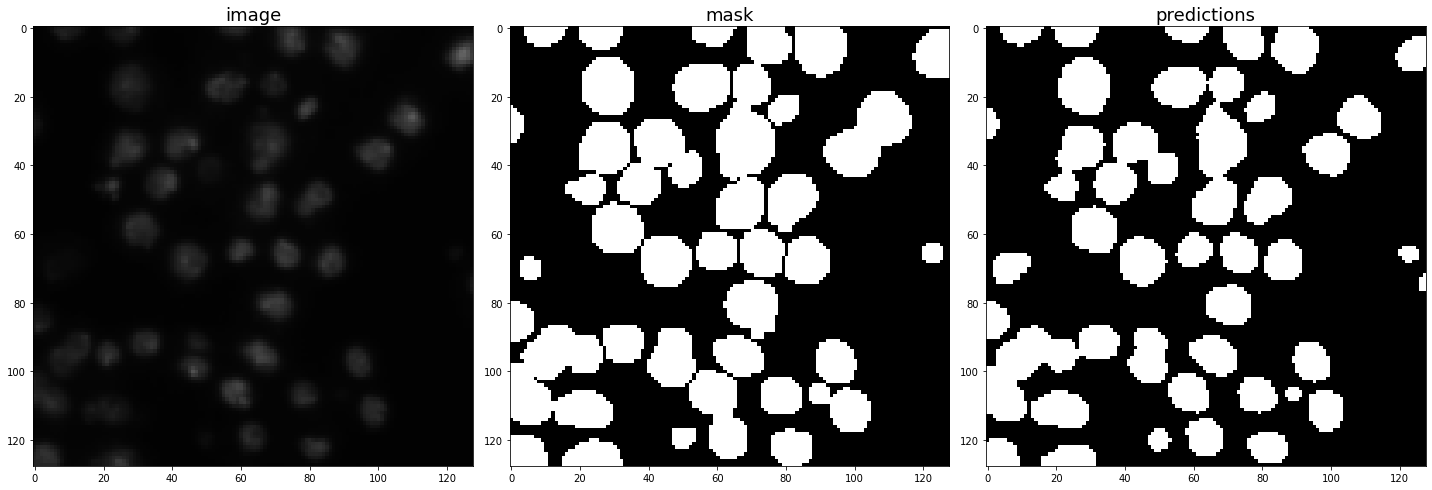

In [83]:
#plotting predicting masks

ix = random.randint(0,602)
plt.figure(figsize = (20,20))

#original training images
plt.subplot(131)
imshow(X_train[ix])
plt.title("image",fontsize = 18)

#Combined mask
plt.subplot(132)
imshow(np.squeeze(y_train[ix]))
plt.title("mask", fontsize = 18)

#the masks U-net model predicts
plt.subplot(133)
imshow(np.squeeze(pred_train_t[ix] > 0.5))
plt.title("predictions", fontsize = 18)
plt.show()


# Showing predicted mask on validation data

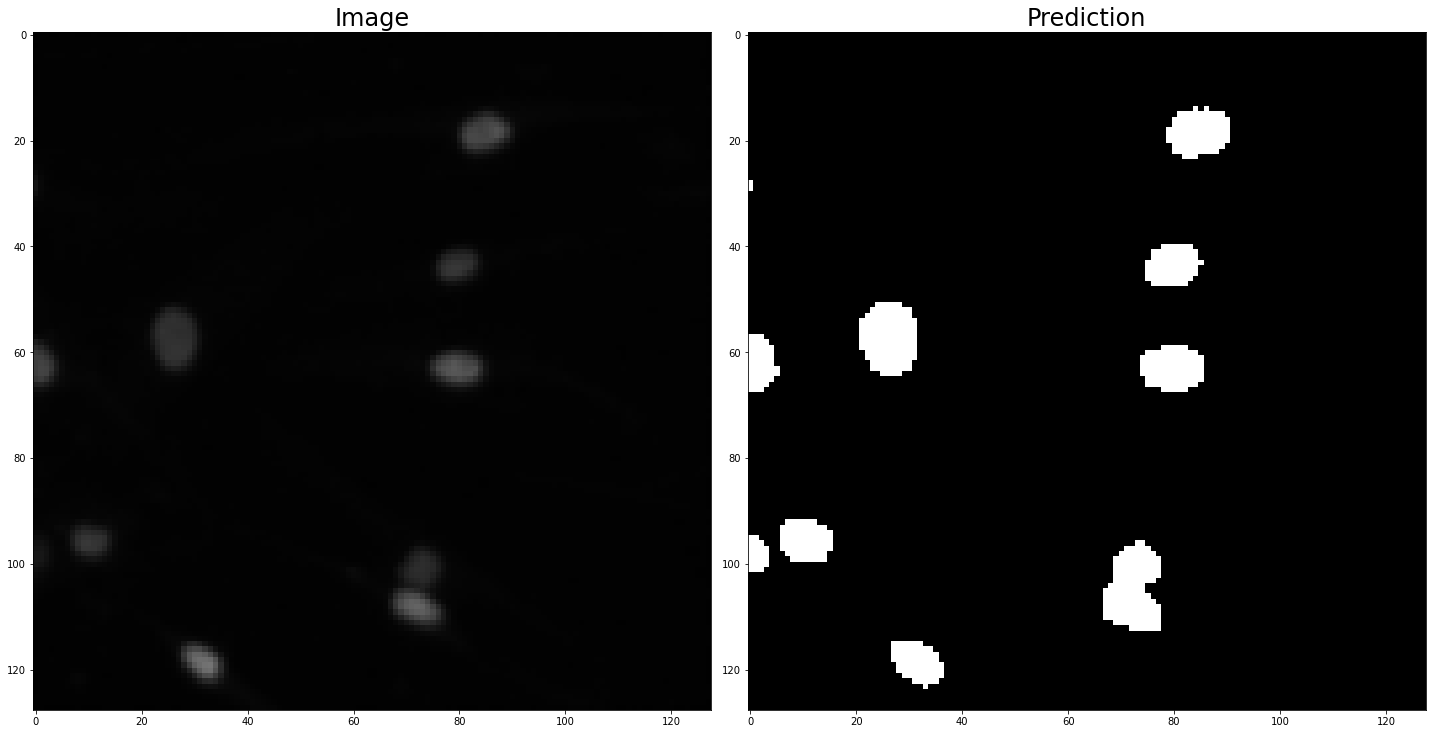

In [76]:
## plotting predicted masks
ix = random.randint(602,668)
plt.figure(figsize = (20,20))

#original training images
plt.subplot(121)
imshow(X_train[ix])
plt.title("Image", fontsize = 24)

#the mask U-net model predicted
plt.subplot(122)
ix = ix - 603
imshow(np.squeeze(pred_val_t[ix] > 0.5))
plt.title("Prediction", fontsize = 24)
plt.show()
       